In [1]:
import streamlit as st
import pandas as pd
import numpy as np
import yaml
import pyodbc
from market_growth_analysis.etl.stagging import *
import pandas as pd
import numpy as np
import pyodbc
import sqlalchemy
from sqlalchemy import create_engine
import sys
import pandas as pd
import matplotlib.pyplot as plt

# sys.path.append('../conf') 
# Load the YAML file
with open('../../conf/global.yml', 'r') as f:
    columns = yaml.safe_load(f)

# Load the YAML file
with open('../../conf/local.yml', 'r') as f:
    credentials = yaml.safe_load(f)


# Get credentials
driver = credentials['warehouse_db']['driver']
server = credentials['warehouse_db']['server']
database = credentials['warehouse_db']['database']
trusted = credentials['warehouse_db']['trusted_connection']
user = credentials['warehouse_db']['user']
password = credentials['warehouse_db']['password']

# Create connection db
conn = pyodbc.connect('Driver={SQL Server};'
                      f'Server={server};'
                      f'Database={database};'
                      'Trusted_Connection=yes;')
cursor = conn.cursor()

In [2]:
# Get data
join_tables_query = '''
select *
from DIM_COMPANY dim
join FACT_BALANCE_SHEET bs on bs.ticker = dim.ticker
join FACT_CASH_FLOW_STATEMENT cfs on cfs.PK = bs.PK
join FACT_INCOME_STATEMENT fis on fis.PK = bs.PK
join FACT_PRICES fp on fp.PK = bs.PK
join FACT_RATIOS fr on fr.PK = bs.PK
'''
data = pd.read_sql(join_tables_query, conn)
# drop duplicated columns
data = data.T.drop_duplicates().T
data['Date'] = pd.to_datetime(data['Date'], format="%Y/%m/%d").dt.strftime("%Y/%m/%d")


C:\Users\germa\AppData\Local\Temp/ipykernel_15408/764186177.py:11: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  data = pd.read_sql(join_tables_query, conn)


In [3]:
data.columns

Index(['ticker', 'company_full_name', 'country', 'industry', 'sector', 'PK',
       'Date', 'Cash On Hand', 'Receivables', 'Inventory', 'Pre-Paid Expenses',
       'Other Current Assets', 'Total Current Assets',
       'Property, Plant, And Equipment', 'Long-Term Investments',
       'Goodwill And Intangible Assets', 'Other Long-Term Assets',
       'Total Long-Term Assets', 'Total Assets', 'Total Current Liabilities',
       'Long Term Debt', 'Other Non-Current Liabilities',
       'Total Long Term Liabilities', 'Total Liabilities', 'Common Stock Net',
       'Retained Earnings (Accumulated Deficit)', 'Comprehensive Income',
       'Other Share Holders Equity', 'Share Holder Equity',
       'Total Liabilities And Share Holders Equity', 'Net Income/Loss',
       'Total Depreciation And Amortization - Cash Flow',
       'Other Non-Cash Items', 'Total Non-Cash Items',
       'Change In Accounts Receivable', 'Change In Inventories',
       'Change In Accounts Payable', 'Change In Assets/L

In [4]:
data['country'].value_counts()

United States           39989
Canada                   1557
China                    1229
Israel                    753
United Kingdom            709
Bermuda                   443
Ireland                   354
Brazil                    350
Netherlands               194
Hong Kong, SAR China      193
Greece                    189
Switzerland               189
Argentina                 178
Germany                   150
Mexico                    142
South Korea               142
Japan                     129
Singapore                 127
India                     123
Australia                 119
Luxembourg                117
Taiwan                    117
France                    115
South Africa               94
Cayman Islands             94
Chile                      86
Colombia                   60
Spain                      56
Belgium                    54
Sweden                     53
Peru                       53
Denmark                    45
Italy                      42
Panama    

In [5]:
data['industry'].value_counts()

Medical - Biomedical and Genetics        3573
Medical - Drug Manufacturing             1682
Technology Services                      1232
Banks - Northeast                        1199
REIT - Other Equity Trusts               1165
                                         ... 
Nanotechnology Equipment and Services      11
Electronics - Military Systems             11
Retail - Mail Order & Direct                9
Printing & Trade Machinery                  8
Periodical Publishing                       2
Name: industry, Length: 252, dtype: int64

In [6]:
columns_to_study = columns['columns_prices'] + columns['columns_ratios'] + columns['column_id']

In [7]:
industry = 'Technology Services'

data_filtered_industry = data[(data['industry'] == industry)&(data['country'] == 'United States')]

In [8]:
len(data_filtered_industry['ticker'].unique())

170

In [9]:
data_to_study = data_filtered_industry[columns_to_study]

In [10]:
data_to_study = data_to_study.dropna(subset='Growth +5')

In [11]:
data_to_study_filled = data_to_study.fillna(value=0)

In [12]:
data_to_study_filled.columns

Index(['longevity', 'Close', 'Volume', 'Growth -1', 'Growth +1', 'Growth +5',
       'Growth -10', 'Growth -5', 'Enterprise Value (EV)', 'EV / Revenue',
       'EV / EBITDA', 'EV / EBIT', 'EV / Invested Capital',
       'Free Cash Flow (FCF)', 'EV / Free Cash Flow', 'P/E', 'P/S', 'P/CF',
       'PK', 'ticker', 'Date'],
      dtype='object')

In [13]:
columns_to_drop = ['Growth +1', 
                #    'Date', 
                #    'ticker', 
                   'Close', 
                   'Volume', 
                   'longevity', 
                   'Enterprise Value (EV)', 
                   'Free Cash Flow (FCF)', 
                   'EV / EBITDA', 
                   'Growth -5', 
                   'Growth -1', 
                   'Growth -10',
                   'EV / Free Cash Flow',
                   'EV / Invested Capital'
                   ]
data_to_study_filled_drop = data_to_study_filled.drop(columns=columns_to_drop)
data_to_study_filled_drop = data_to_study_filled_drop.set_index(keys='PK')

In [14]:
data_to_study_filled_drop['Growth +5']*100

PK
1951      99.872609
1954      46.266470
1949      95.422036
1950     106.206894
1957      -0.865800
            ...    
28727     55.196909
28721    104.801103
28728    481.468891
28723    -53.445554
28730     84.955001
Name: Growth +5, Length: 334, dtype: float64

In [15]:
(data_to_study_filled_drop['Growth +5']*100).describe()

count     334.000000
mean      110.025355
std       440.677658
min       -99.999800
25%       -56.975394
50%        -0.431504
75%        90.979180
max      3649.999944
Name: Growth +5, dtype: float64

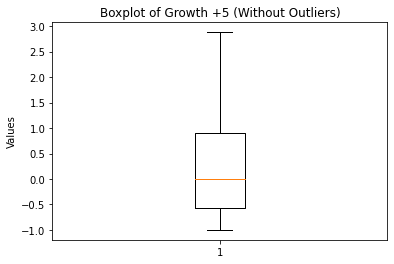

In [16]:
import matplotlib.pyplot as plt

# Assuming data_to_study_filled_drop is your DataFrame
plt.boxplot(data_to_study_filled_drop['Growth +5'], showfliers=False)
plt.title('Boxplot of Growth +5 (Without Outliers)')
plt.ylabel('Values')
plt.show()


In [17]:
# data_to_study_filled_drop['target'] = data_to_study_filled_drop['Growth +5'] > 0
# data_to_study_filled_drop['target'] = data_to_study_filled_drop['target'].astype(int)

import pandas as pd
import numpy as np

# Assuming you have a DataFrame named data_to_study_final
# data_to_study_filled_drop['target'] = np.where(data_to_study_filled_drop['Growth +5'] < 0, 0, 
#                         np.where(data_to_study_filled_drop['Growth +5'] <= data_to_study_filled_drop['Growth +5'].quantile(0.9), 1, 2))

data_to_study_filled_drop['target'] = np.where(data_to_study_filled_drop['Growth +5'] < 0, 0, 1)

# data_to_study_filled_drop['target'] = np.where(data_to_study_filled_drop['Growth +5'] < 0, 0, 
#                                     np.where(data_to_study_filled_drop['Growth +5'] < 2.5, 1, 2))

num_classes = len(data_to_study_filled_drop['target'].unique())
num_classes

2

In [18]:
data_to_study_filled_drop['target'].value_counts()

1    167
0    167
Name: target, dtype: int64

In [19]:
data_to_study_filled_drop['Growth +5'].quantile(0.9)

2.8773593254170655

In [20]:
# data_to_study_final = data_to_study_filled_drop.drop(columns='Growth +5')
data_to_study_final = data_to_study_filled_drop

In [21]:
data_to_study_final.shape

(334, 9)

In [22]:
data_to_study_final['target'].value_counts()

1    167
0    167
Name: target, dtype: int64

# Create LSTM Model

In [23]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder

## Prepare Data

In [26]:
company_to_study = data_to_study_final['ticker'].iloc[0]
company_to_study

'ALOT'

In [27]:
data_to_study_final[data_to_study_final['ticker'] == company_to_study]

,Growth +5,EV / Revenue,EV / EBIT,P/E,P/S,P/CF,ticker,Date,target
PK,,,,,,,,,
1951,0.998726,0.686037,17.652705,28.035714,0.825721,43.514024,ALOT,2011/01/31,1
1954,0.462665,1.276884,57.132432,32.523809,1.532847,-23.563653,ALOT,2014/01/31,1
1949,0.954220,0.577601,8.962457,17.474999,0.724286,7.475538,ALOT,2009/01/31,1
1950,1.062069,0.624060,11.914649,19.078947,0.835041,9.140582,ALOT,2010/01/31,1
1957,-0.008658,0.947251,14.847145,24.749999,1.066024,15.093904,ALOT,2017/01/31,0
1956,-0.314850,1.134516,18.097571,25.721311,1.238353,15.170181,ALOT,2016/01/31,0
1958,-0.018519,1.249376,26.178954,28.723404,0.835112,25.430317,ALOT,2018/01/31,0
1952,0.721739,0.793137,81.077526,19.166667,0.984840,10.928993,ALOT,2012/01/31,1
1955,-0.167893,1.186292,14.493887,24.916666,1.325662,47.606554,ALOT,2015/01/31,0


In [34]:
# Load your financial data into a DataFrame (replace 'your_data.csv' with your dataset)
df = data_to_study_final.copy()

# Define the sequence length and other hyperparameters
n_steps = 5 # years to study prior
# n_features = len(df.columns) - 1  # Replace with the number of feature columns in your dataset
num_companies = len(df['ticker'].unique())  # Assuming you have a 'ticker' column

# Use LabelEncoder to convert 'ticker' values to numerical labels
label_encoder = LabelEncoder()
df['ticker'] = label_encoder.fit_transform(df['ticker'])

# Prepare an empty list to store sequences for all companies
all_sequences = []
all_targets = []  # To store the corresponding target values
all_sequences_train = []
all_sequences_test = []
all_targets_train = []  # To store the corresponding target values
all_targets_test = []  # To store the corresponding target values
all_info_rows_test = []
all_info_rows_train = []

# Define the percentage of data to allocate for testing
test_size = 0.2

# Iterate through unique company labels
for label in df['ticker'].unique():
    # Filter data for the current company label
    company_data = df[df['ticker'] == label]

    # Sort data by date
    company_data_complete = company_data.sort_values(by='Date')
    company_data = company_data.sort_values(by='Date').drop(columns=['Date', 'ticker', 'Growth +5'])
    n_features = len(company_data.columns) - 1 
    # Create sequences for the current company
    sequences = []
    targets = []  # To store the corresponding target values
    info_rows = []
    sequences_train = []
    sequences_test = []
    targets_train = []
    targets_test = []
    for i in range(len(company_data) - n_steps + 1):
        sequence = company_data.iloc[i:i + n_steps, 0:n_features].values  # Adjust column indices
        target = company_data.iloc[i + n_steps - 1, n_features]  # Assuming the target column is the last one
        info_row = company_data_complete.iloc[i + n_steps - 1]
        sequences.append(sequence)
        targets.append(target)
        info_rows.append(info_row)

    # Calculate the index to split the data
    split_index = int(len(targets) * (1 - test_size))

    # Split the data into training and testing sets
    sequences_train = sequences[:split_index]
    sequences_test = sequences[split_index:]
    targets_train = targets[:split_index]
    targets_test = targets[split_index:]
    info_rows_train = info_rows[:split_index]
    info_rows_test = info_rows[split_index:]

    # Append sequences and corresponding targets to the lists
    all_sequences.extend(sequences)
    all_targets.extend(targets)
    # Append sequences and corresponding targets to the lists
    all_sequences_train.extend(sequences_train)
    all_sequences_test.extend(sequences_test)
    all_targets_train.extend(targets_train)
    all_targets_test.extend(targets_test)
    all_info_rows_train.extend(info_rows_train)
    all_info_rows_test.extend(info_rows_test)

In [40]:
data_to_study_final[data_to_study_final['ticker'] == company_to_study].sort_values(by='Date')

,Growth +5,EV / Revenue,EV / EBIT,P/E,P/S,P/CF,ticker,Date,target
PK,,,,,,,,,
1949,0.954220,0.577601,8.962457,17.474999,0.724286,7.475538,ALOT,2009/01/31,1
1950,1.062069,0.624060,11.914649,19.078947,0.835041,9.140582,ALOT,2010/01/31,1
1951,0.998726,0.686037,17.652705,28.035714,0.825721,43.514024,ALOT,2011/01/31,1
1952,0.721739,0.793137,81.077526,19.166667,0.984840,10.928993,ALOT,2012/01/31,1
1953,0.350000,0.810107,16.950786,6.944444,1.222233,19.370955,ALOT,2013/01/31,1
1954,0.462665,1.276884,57.132432,32.523809,1.532847,-23.563653,ALOT,2014/01/31,1
1955,-0.167893,1.186292,14.493887,24.916666,1.325662,47.606554,ALOT,2015/01/31,0
1956,-0.314850,1.134516,18.097571,25.721311,1.238353,15.170181,ALOT,2016/01/31,0
1957,-0.008658,0.947251,14.847145,24.749999,1.066024,15.093904,ALOT,2017/01/31,0


In [37]:
all_sequences_train

[array([[ 0.57760117,  8.96245694, 17.47499943,  0.72428571,  7.47553787],
        [ 0.62405964, 11.91464905, 19.07894737,  0.83504083,  9.14058226],
        [ 0.68603738, 17.65270455, 28.03571395,  0.8257212 , 43.5140244 ],
        [ 0.793137  , 81.07752567, 19.16666712,  0.98484045, 10.92899331],
        [ 0.81010715, 16.95078606,  6.94444444,  1.22223311, 19.37095522]]),
 array([[  0.62405964,  11.91464905,  19.07894737,   0.83504083,
           9.14058226],
        [  0.68603738,  17.65270455,  28.03571395,   0.8257212 ,
          43.5140244 ],
        [  0.793137  ,  81.07752567,  19.16666712,   0.98484045,
          10.92899331],
        [  0.81010715,  16.95078606,   6.94444444,   1.22223311,
          19.37095522],
        [  1.27688388,  57.13243237,  32.52380916,   1.53284667,
         -23.56365281]]),
 array([[  0.68603738,  17.65270455,  28.03571395,   0.8257212 ,
          43.5140244 ],
        [  0.793137  ,  81.07752567,  19.16666712,   0.98484045,
          10.92899331]

# Split train test

In [29]:
from sklearn.model_selection import train_test_split

# Define the percentage of data to allocate for testing
test_size = 0.2

# Calculate the index to split the data
split_index = int(len(all_targets) * (1 - test_size))

# Split the data into training and testing sets
X_train, X_test = all_sequences_train, all_sequences_test
y_train, y_test = all_targets_train, all_targets_test

train_all_info, test_all_info = all_info_rows_train, all_info_rows_test